In [1]:
##导入包
import numpy as np
from matplotlib import pyplot as plt

In [2]:
##计算城市之间的距离矩阵
def get_distance(citys):
    N = len(citys)
    distance = np.zeros((N, N))
    for i, curr_point in enumerate(citys):
        line = []
        [line.append(np.linalg.norm(np.array(curr_point)-np.array(other_point))) if i != j else line.append(0.0) for j, other_point in enumerate(citys)]
        distance[i] = line
    return distance

In [3]:
##更新距离
def calc_distance(path):
    dis = 0.0
    for i in range(len(path) - 1):
        dis += distance[path[i]][path[i+1]]
    return dis

In [4]:
##利用CHNN动态方程计算输入状态的增量
def calc_du(V, distance):
    a = np.sum(V, axis=0) - 1  # 按列相加
    b = np.sum(V, axis=1) - 1  # 按行相加
    t1 = np.zeros((N, N))
    t2 = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            t1[i, j] = a[j]
    for i in range(N):
        for j in range(N):
            t2[j, i] = b[j]
    # 将第一列移动到最后一列
    c_1 = V[:, 1:N]
    c_0 = np.zeros((N, 1))
    c_0[:, 0] = V[:, 0]
    c = np.concatenate((c_1, c_0), axis=1)
    c = np.dot(distance, c)
    return -A * (t1 + t2) - D * c

In [5]:
##由一阶欧拉方法更新神经网络下一个时刻的输入状态
def calc_U(U, du, step):
    return U + du * step

##由sigmoid函数更新神经网络下一个时刻的输出状态
def calc_V(U, U0):
    return 1 / 2 * (1 + np.tanh(U / U0))

In [6]:
# 计算能量函数E
def calc_energy(V, distance):
    t1 = np.sum(np.power(np.sum(V, axis=0) - 1, 2))
    t2 = np.sum(np.power(np.sum(V, axis=1) - 1, 2))
    idx = [i for i in range(1, N)]
    idx = idx + [0]
    Vt = V[:, idx]
    t3 = distance * Vt
    t3 = np.sum(np.sum(np.multiply(V, t3)))
    e = 0.5 * (A * (t1 + t2) + D * t3)
    return e

In [7]:
# 检查路径的正确性
def check_path(V):
    newV = np.zeros([N, N])
    route = []
    for i in range(N):
        mm = np.max(V[:, i])
        for j in range(N):
            if V[j, i] == mm:
                newV[j, i] = 1
                route += [j]
                break
    return route, newV

In [8]:
##可视化
def draw(citys, H_path, energys):
    fig = plt.figure()
    ax = fig.add_subplot(121)
    plt.xlim(0, 7)
    plt.ylim(0, 7)
    for (from_, to_) in H_path:
        p1 = plt.Circle(citys[from_], 0.2, color='lightblue')
        p2 = plt.Circle(citys[to_], 0.2, color='lightblue')
        ax.add_patch(p1)
        ax.add_patch(p2)
        ax.plot((citys[from_][0], citys[to_][0]), (citys[from_][1], citys[to_][1]), color='lightblue')
        ax.annotate(s=chr(97 + to_), xy=citys[to_], xytext=(-8, -4), textcoords='offset points', fontsize=20)
    ax.axis('equal')
    ax.grid()
    plt.show()

第98次迭代找到的次优解距离为：24.81769306884381，能量为：167.69884290634428，路径为：
e,d,g,b,c,a,f,h,e
第312次迭代找到的次优解距离为：18.556395895082645，能量为：287.6746612565932，路径为：
e,f,d,g,b,a,c,h,e
第1223次迭代找到的次优解距离为：16.974836860209646，能量为：443.3531894280594，路径为：
f,d,b,c,h,a,g,e,f
第2428次迭代找到的次优解距离为：15.764091950405117，能量为：247.35776586346293，路径为：
d,a,b,h,c,g,e,f,d
第3077次迭代找到的次优解距离为：15.246537600251445，能量为：267.86428925529253，路径为：
d,a,b,c,h,g,e,f,d
第5401次迭代找到的次优解距离为：14.084259940083067，能量为：254.90216337161274，路径为：
a,c,h,g,e,d,f,b,a


<ipython-input-8-a47e4a10e982>:13: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.annotate(s=chr(97 + to_), xy=citys[to_], xytext=(-8, -4), textcoords='offset points', fontsize=20)


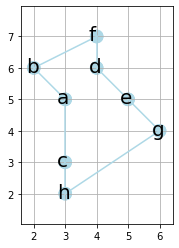

In [17]:
if __name__ == '__main__':
    citys = np.array([[3, 5], [2, 6], [3, 3], [4, 6], [5, 5], [4, 7], [6, 4], [3, 2]])
    distance = get_distance(citys)
    N = len(citys)
    
    # 设置初始值
    A = N * N
    D = N / 2
    U0 = 0.0009  # 初始电压
    step = 0.0001  # 步长
    num_iter = 10000  # 迭代次数
    
    # 初始化神经网络的输入状态（电路的输入电压U）
    U = 1 / 2 * U0 * np.log(N - 1) + (2 * (np.random.random((N, N))) - 1)
    # 初始化神经网络的输出状态（电路的输出电压V）
    V = calc_V(U, U0)
    energys = np.array([0.0 for x in range(num_iter)])  # 每次迭代的能量
    best_distance = np.inf  # 最优距离
    best_route = []  # 最优路线
    H_path = []  # 哈密顿回路
    
    # 开始迭代训练网络
    for n in range(num_iter):
        du = calc_du(V, distance)
        U = calc_U(U, du, step)
        V = calc_V(U, U0)
        energys[n] = calc_energy(V, distance)
        route, newV = check_path(V)
        
        if len(np.unique(route)) == N:
            route.append(route[0])
            dis = calc_distance(route)
            if dis < best_distance:
                H_path = []
                best_distance = dis
                best_route = route
                [H_path.append((route[i], route[i + 1])) for i in range(len(route) - 1)]
                print('第{}次迭代找到的次优解距离为：{}，能量为：{}，路径为：'.format(n, best_distance, energys[n]))
                [print(chr(97 + v), end=',' if i < len(best_route) - 1 else '\n') for i, v in enumerate(best_route)]
    if len(H_path) > 0:
        draw(citys, H_path, energys)
    else:
        print('没有找到最优解')